# ChannelTS
A `ChannelTS` object is a container for a single channel.  The data are stored in an `xarray.DataArray` and indexed by time according to the metadata provided.  Here we will make a simple `electric` channel and look at how to interogate it.

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS
from mt_metadata.timeseries import Electric, Run, Station

2022-09-12 16:26:08,013 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


Here create some metadata, the keys are the `time_period.start` and the `sample_rate`. 

In [2]:
ex_metadata = Electric()
ex_metadata.time_period.start = "2020-01-01T00:00:00"
ex_metadata.sample_rate = 1.0
ex_metadata.component = "ex"
ex_metadata.dipole_length = 100.
ex_metadata.units = "millivolts"

Create `Station` and `Run` metadata

In [3]:
station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

Create "realistic" data 

In [4]:
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

In [5]:
ex = ChannelTS(channel_type="electric",
              data=data,
              channel_metadata=ex_metadata,
              run_metadata=run_metadata,
              station_metadata=station_metadata)

In [6]:
ex

Channel Summary:
	Station:      mt001
	Run:          001
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:16+00:00
	N Samples:    4096

## Get a slice of the data
Here we will provide a start time of the slice and the number of samples that we want the slice to be


In [7]:
ex_slice = ex.get_slice("2020-01-01T00:00:00", n_samples=256)

In [8]:
ex_slice

Channel Summary:
	Station:      mt001
	Run:          001
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T00:04:15.062271+00:00
	N Samples:    256

## Plot the data
This is a work in progress, but this can be done through the `xarray` container.

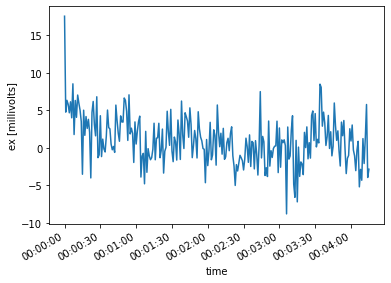

In [9]:
ex_slice._ts.plot()

## Convert to an `xarray`
We can convert the `ChannelTS` object to an `xarray.DataArray` which could be easier to use.

In [10]:
ex_xarray = ex.to_xarray()

In [11]:
ex_xarray

<xarray.DataArray 'ex' (time: 4096)>
array([17.55326313,  4.75550852,  6.32715281, ..., -4.90105606,
       -0.4700183 ,  2.42377933])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-01T01:08:16
Attributes:
    channel_number:             0
    component:                  ex
    data_quality.rating.value:  0
    dipole_length:              100.0
    filter.applied:             [False]
    filter.name:                []
    measurement_azimuth:        0.0
    measurement_tilt:           0.0
    negative.elevation:         0.0
    negative.id:                None
    negative.latitude:          0.0
    negative.longitude:         0.0
    negative.manufacturer:      None
    negative.type:              None
    positive.elevation:         0.0
    positive.id:                None
    positive.latitude:          0.0
    positive.longitude:         0.0
    positive.manufacturer:      None
    positive.type:              None
    sample_rate:                1.0
    time_period.end:            2020-01-01T01:08:16+00:00
    time_period.start:          2020-01-01T00:00:00+00:00
    type:                       electric
    units:                      millivolts
    station.id:                 mt001
    run.id:                     001

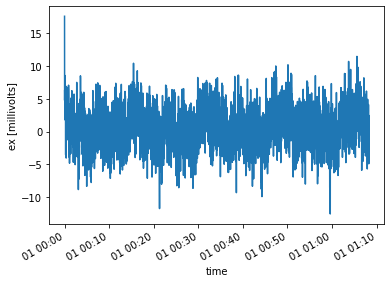

In [12]:
ex_xarray.plot()

## Convert to an `Obspy.Trace` object
The `ChannelTS` object can be converted to an `obspy.Trace` object.  This can be useful when dealing with data received from a mainly seismic archive like IRIS.  This can also be useful for using some tools provided by [Obspy](https://docs.obspy.org/).  

**Note** there is a loss of information when doing this because an `obspy.Trace` is based on miniSEED data formats which has minimal metadata.  

In [13]:
ex.station_metadata.fdsn.id = "mt001"
ex_trace = ex.to_obspy_trace()

In [14]:
ex_trace

.mt001..LQN | 2020-01-01T00:00:00.000000Z - 2020-01-01T01:08:15.000000Z | 1.0 Hz, 4096 samples

## Convert from an `Obspy.Trace` object
We can reverse that and convert an `obspy.Trace` into a `ChannelTS`.  Again useful when dealing with seismic dominated archives.

In [15]:
ex_from_trace = ChannelTS()
ex_from_trace.from_obspy_trace(ex_trace)

In [16]:
ex_from_trace

Channel Summary:
	Station:      mt001
	Run:          None
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:16+00:00
	N Samples:    4096

In [17]:
ex

Channel Summary:
	Station:      mt001
	Run:          001
	Channel Type: electric
	Component:    ex
	Sample Rate:  1.0
	Start:        2020-01-01T00:00:00+00:00
	End:          2020-01-01T01:08:16+00:00
	N Samples:    4096

On comparison you can see the loss of metadata information.  

## Calibrate 

Removing the instrument response to calibrate the data is an important step in processing the data.  A convenience function `ChannelTS.remove_instrument_response` is supplied just for this.  
Currently, it will calibrate the whole time series at once and therefore may be slow for large data sets.  

**SEE ALSO**: `Make Data From IRIS` examples for working examples.

In [18]:
help(ex.remove_instrument_response)

Help on method remove_instrument_response in module mth5.timeseries.channel_ts:

remove_instrument_response(**kwargs) method of mth5.timeseries.channel_ts.ChannelTS instance
    Remove instrument response from the given channel response filter
    
    The order of operations is important (if applied):
    
        1) detrend
        2) zero mean
        3) zero pad
        4) time window
        5) frequency window
        6) remove response
        7) undo time window
        8) bandpass
    
    **kwargs**
    
    :param plot: to plot the calibration process [ False | True ]
    :type plot: boolean, default True
    :param detrend: Remove linar trend of the time series
    :type detrend: boolean, default True
    :param zero_mean: Remove the mean of the time series
    :type zero_mean: boolean, default True
    :param zero_pad: pad the time series to the next power of 2 for efficiency
    :type zero_pad: boolean, default True
    :param t_window: Time domain windown name see `scipy